In [1]:
from pathlib import Path

import jax
import matplotlib.pyplot as plt
import numpy as np
import scipy.spatial as scspatial
from dynamical_systems.continuous import Lorenz63
from dynamical_systems.transforms import TransformedODE
from dynamics_discovery.data import TimeSeriesDataset
from dynamics_discovery.pushforward import estimate_pushforward_matrices
from itertools import product
from jaxtyping import Float
from tqdm import tqdm
from einops import rearrange
import colorcet as cc
from dynamics_discovery.loss_functions import (
    tangent_evolution_matrix,
    PushforwardMatchingMSE,
)
from mpl_toolkits.axes_grid1 import make_axes_locatable

jax.config.update("jax_enable_x64", True)
plt.style.use("matplotlib_utils.styles.dash_gridded")

datadir = Path("../../data")

In [3]:
from dynamics_discovery.training.vanilla import VanillaTrainer
import optax

trainer = VanillaTrainer(optax.adamw(learning_rate=2e-4))

wandb: Network error (ConnectionError), entering retry loop.
wandb: Network error (ConnectionError), entering retry loop.


MailboxClosedError: 

In [2]:
noise = 0.1
downsample = 2
dataset, transform = (
    TimeSeriesDataset(
        *TimeSeriesDataset.from_hdf5(datadir / "lorenz63_large.hdf5")[::100]
    )
    .downsample(downsample)
    .split_along_time(500)[0]
    .add_noise(noise)
    .standardize()
)

lorenz_scaled = TransformedODE(Lorenz63(), transform)

dataset.u.shape

(50, 500, 3)

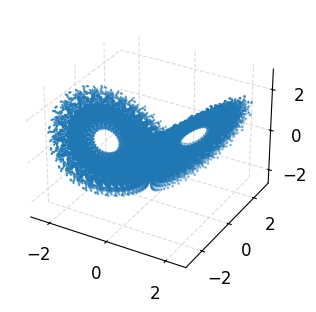

In [3]:
fig, ax = plt.subplots(1, 1, figsize=(5, 3), subplot_kw={"projection": "3d"})
ax.scatter(*dataset.u.reshape(-1, 3).T, s=0.5)

In [4]:
radius = 1.0
min_neighbors = 30

In [ ]:
rollout = 4

M1_2, M2_2, scores_2 = estimate_pushforward_matrices(
    dataset,
    radius=radius,
    dim_project=2,
    num_neighbor_threshold=min_neighbors,
    rollout=rollout,
)

  0%|          | 0/25000 [00:00<?, ?it/s]

100%|██████████| 25000/25000 [00:26<00:00, 953.90it/s] 
24800it [05:01, 82.29it/s] 


In [55]:
M1_2.shape

(50, 496, 3, 2)

In [7]:
test_pts = np.array([[1, 0], [0, 1]]) @ np.permute_dims(M1_2, (0, 1, 3, 2))
test_pts.shape

(50, 496, 2, 3)

In [ ]:
M_true = jax.lax.map(
    lambda x0_: tangent_evolution_matrix(
        lorenz_scaled, x0_, dataset.t[0][0 : rollout + 1]
    )[1],
    dataset.u[:, :-rollout].reshape(-1, 3),
    batch_size=2048,
)
M_true = rearrange(
    M_true,
    "(trajs time) rollout dim1 dim2 -> trajs time rollout dim1 dim2",
    trajs=dataset.u.shape[0],
)
M_true.shape

(50, 496, 4, 3, 3)

In [9]:
pts_true = np.einsum("abij,abckj->abcik", test_pts, M_true)
pts_true.shape

(50, 496, 4, 2, 3)

In [10]:
pts_pred = np.array([[1, 0], [0, 1]]) @ M2_2
pts_pred.shape

(50, 496, 4, 2, 3)

In [11]:
err = np.mean((pts_true - pts_pred) ** 2, axis=(-1, -2))
scatter_kwargs = {"s": 2.0, "alpha": 0.8}

In [12]:
scores_flat = rearrange(scores_2, "traj time -> (traj time)")
errs_flat = rearrange(err, "traj time rollout -> (traj time) rollout")
mask = scores_flat < 1.0

Text(0.5, 0.98, 'Jacobian time-T map log error (noise = 0.1%, $r=1.0$)')

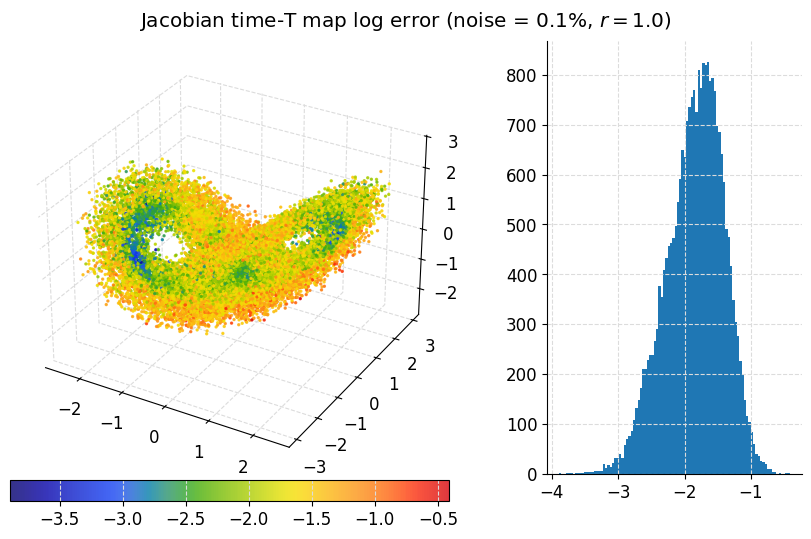

In [13]:
rollout_ind = 3
fig = plt.figure(figsize=(8, 5), layout="constrained")
subfigs = fig.subfigures(1, 2, wspace=0.1, width_ratios=(1.5, 1))
ax0 = subfigs[0].subplots(1, 1, subplot_kw={"projection": "3d"})

p = ax0.scatter(
    *dataset.u[:, :-rollout].reshape(-1, 3)[mask].T,
    c=np.log10(errs_flat[mask, rollout_ind]),
    cmap=cc.m_rainbow4,
    **scatter_kwargs,
)
divider = make_axes_locatable(ax0)
cax = divider.append_axes("bottom", size="5%", pad=0.05, axes_class=plt.Axes)

subfigs[0].colorbar(p, cax=cax, orientation="horizontal")

ax1 = subfigs[1].subplots(1, 1)
ax1.hist(np.log10(errs_flat[mask, rollout_ind]), bins=100)

fig.suptitle(f"Jacobian time-T map log error (noise = {noise}%, $r={radius}$)")

Text(0.5, 0.98, 'PCA unexplained variance (noise = 0.1%, $r=1.0$)')

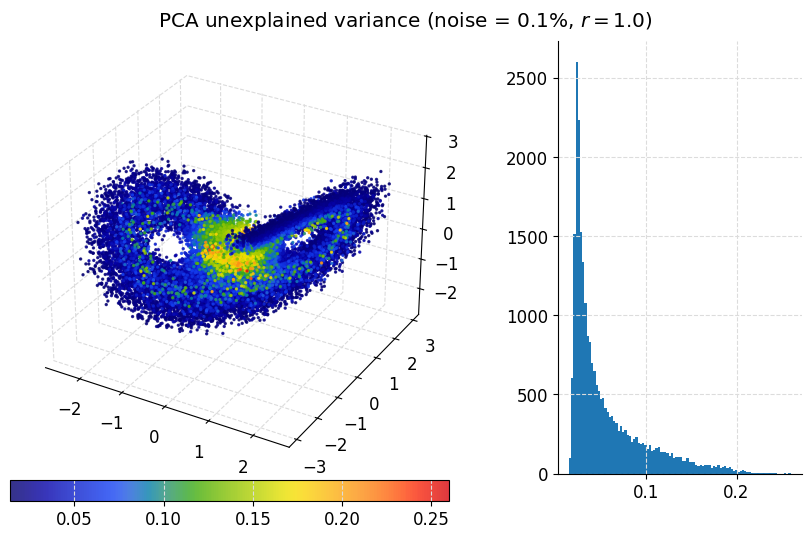

In [14]:
fig = plt.figure(figsize=(8, 5), layout="constrained")
subfigs = fig.subfigures(1, 2, wspace=0.1, width_ratios=(1.5, 1))
ax0 = subfigs[0].subplots(1, 1, subplot_kw={"projection": "3d"})
p = ax0.scatter(
    *dataset.u[:, :-rollout].reshape(-1, 3)[mask].T,
    c=scores_flat[mask],
    cmap=cc.m_rainbow4,
    **scatter_kwargs,
)
divider = make_axes_locatable(ax0)
cax = divider.append_axes("bottom", size="5%", pad=0.05, axes_class=plt.Axes)

subfigs[0].colorbar(p, cax=cax, orientation="horizontal")

ax1 = subfigs[1].subplots(1, 1)
ax1.hist(scores_flat[mask], bins=100)

fig.suptitle(f"PCA unexplained variance (noise = {noise}%, $r={radius}$)")

Text(0.5, 1.0, 'Noise = 0.1, Radius = 1.0')

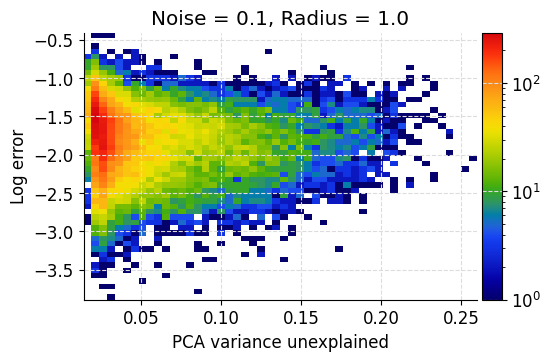

In [20]:
import matplotlib.colors as mcolors

rollout_ind = 3
fig, ax = plt.subplots(1, 1, figsize=(5, 3.5))

*_, h = ax.hist2d(
    scores_flat[mask],
    np.log10(errs_flat[mask, rollout_ind]),
    bins=50,
    cmap=cc.cm.rainbow4,
    norm=mcolors.LogNorm(),
)

divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)

fig.colorbar(h, cax=cax)

ax.set_xlabel("PCA variance unexplained")
ax.set_ylabel("Log error")
ax.set_title(f"Noise = {noise}, Radius = {radius}")

# ax.set_ylim((-0.05, 1.0))

### Test dataloading with the auxillary data (precomputed pushforward matrices)

In [18]:
from dynamics_discovery.data.loaders import SegmentLoader, RandomSampleBatching
import numpy as np

weights = masks = np.logical_and(scores_2 < 0.7, scores_2 >= 0)
loader = SegmentLoader(
    dataset,
    rollout + 1,
    RandomSampleBatching(batch_size=1024),
    aux_data=(M1_2, M2_2, weights),
)
loader_state = loader.init()
batch, _ = loader.load_batch(loader_state)

In [19]:
(t_batch, u_batch), (M1_batch, M2_batch, weights) = batch
t_batch.shape

(1024, 5)

In [20]:
M_true_batch = jax.lax.map(
    lambda x0_: tangent_evolution_matrix(lorenz_scaled, x0_, t_batch[0])[1],
    u_batch[:, 0],
    batch_size=2048,
)
M_true_batch.shape

(1024, 4, 3, 3)

In [21]:
M1_batch.shape

(1024, 3, 2)

In [22]:
# test_pts_batch = np.array([[1, 0], [0, 1]]) @ np.permute_dims(M1_batch, (0, 2, 1))
test_pts_batch = np.permute_dims(M1_batch, (0, 2, 1))
pts_true_batch = np.einsum("bij,btkj->btik", test_pts_batch, M_true_batch)
# pts_pred_batch = np.array([[1, 0], [0, 1]]) @ M2_batch
pts_pred_batch = M2_batch

err = np.mean((pts_true_batch - pts_pred_batch) ** 2, axis=(-1, -2, -3)) * weights

In [23]:
err

Array([0.01436646, 0.02921632, 0.00625518, ..., 0.01903457, 0.0067966 ,
       0.00426155], dtype=float64)

In [24]:
from dynamics_discovery.models import NeuralODE

model = NeuralODE(dim=3, width=64, depth=3)
M_nn_batch = jax.lax.map(
    lambda x0_: tangent_evolution_matrix(model, x0_, t_batch[0])[1],
    u_batch[:, 0],
    batch_size=1024,
)
pts_nn_batch = np.einsum("bij,btkj->btik", test_pts_batch, M_nn_batch)
err_nn = np.mean((pts_nn_batch - pts_pred_batch) ** 2, axis=(-1, -2, -3)) * weights

Text(0.5, 0.92, 'Data-estimated vs Untrained Neural ODE')

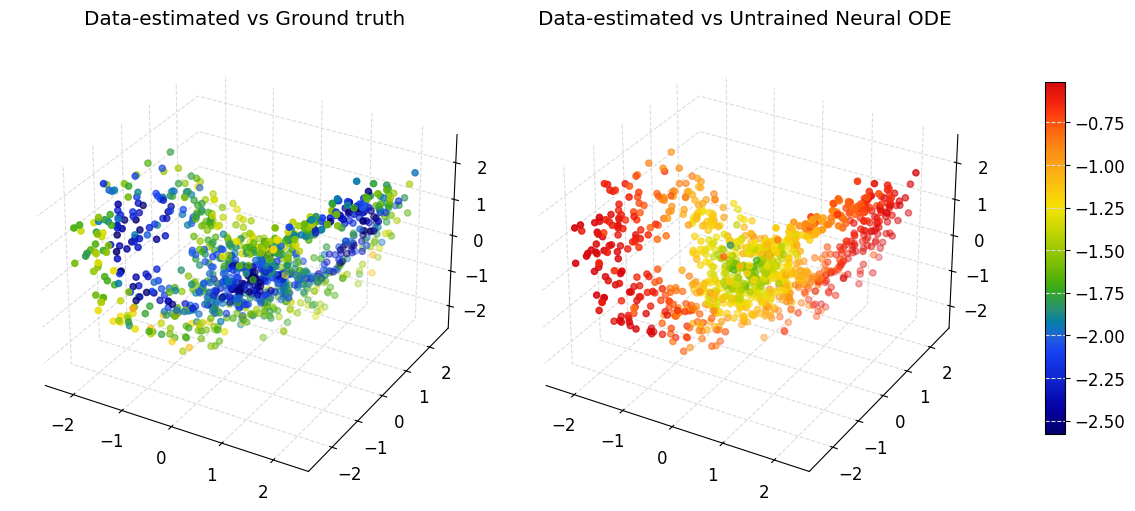

In [25]:
from matplotlib_utils.plots import colored_scatterplot

fig = colored_scatterplot(
    data=[u_batch[:, 0].T] * 2,
    colors=[np.log10(err), np.log10(err_nn)],
    cmap=cc.m_rainbow4,
)
fig.axes[0].set_title("Data-estimated vs Ground truth")
fig.axes[1].set_title("Data-estimated vs Untrained Neural ODE")


In [26]:
loss_fn = PushforwardMatchingMSE(weight=1.0)
loss_fn(model, batch)

(Array(0.30344658, dtype=float64),
 {'mse': Array(0.16800638, dtype=float64),
  'DF_loss': Array(0.1354402, dtype=float64)})

In [27]:
from dynamics_discovery.models import ODEModel

loss_fn = PushforwardMatchingMSE(weight=1.0)
loss_fn(ODEModel(lorenz_scaled), batch)

(Array(0.03191701, dtype=float64),
 {'mse': Array(0.01503155, dtype=float64),
  'DF_loss': Array(0.01688546, dtype=float64)})

TODO: Make step-by-step visualization of what is being computed

1. Neighborhood selection for $u_t$ and $u_{t+\Delta t}$
2. PCA on the matrix of to-neighbor distances to determine local tangent space coordinates
3. Linear regression to determine the pushforward mapping between the tangent spaces 

In [ ]:
traj_ind, time_ind = 10, 100
radius = 0.2
tree = scspatial.KDTree(dataset.u[:, :-1].reshape(-1, 3))
x0, x1 = dataset.u[traj_ind, time_ind], dataset.u[traj_ind, time_ind + 1]

neighbors_inds0 = np.divmod(
    np.asarray(tree.query_ball_point(x0, radius)), dataset.u.shape[1] - 1
)
x_neighbors0 = dataset.u[*neighbors_inds0]
x_neighbors0_next = dataset.u[neighbors_inds0[0], neighbors_inds0[1] + 1]

neighbors_inds = np.asarray(tree.query_ball_point(x1, radius))
x_neighbors1 = dataset.u[*np.divmod(neighbors_inds, dataset.u.shape[1] - 1)]

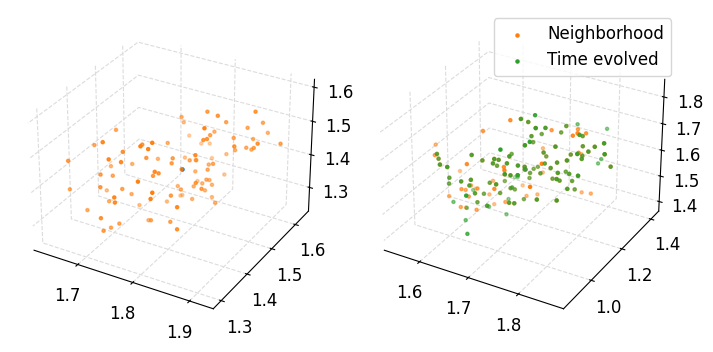

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(7, 5), subplot_kw={"projection": "3d"})
scatter_kwargs = {"s": 5.0}
axes[0].scatter(*x0, **scatter_kwargs)
axes[0].scatter(*x_neighbors0.T, s=5.0)

axes[1].scatter(*x1, s=5.0)
axes[1].scatter(*x_neighbors1.T, s=5.0, label="Neighborhood")
axes[1].scatter(*x_neighbors0_next.T, **scatter_kwargs, label="Time evolved")
axes[1].legend()

s0=array([0.98809828, 0.91666413, 0.45476596])
s1=array([1.17606915, 1.00608126, 0.52100589])


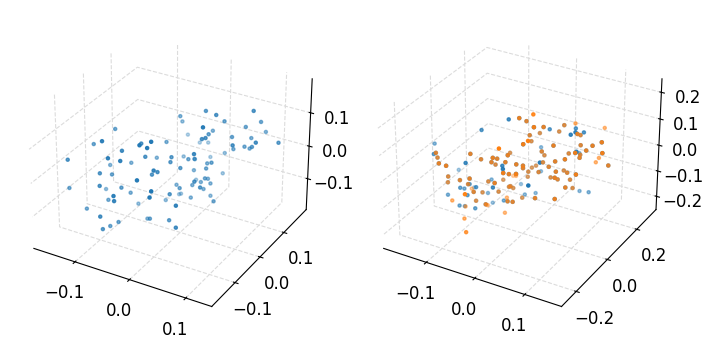

In [ ]:
dx0 = x_neighbors0 - x0
dx1 = x_neighbors1 - x1
dx0_next = x_neighbors0_next - x1

u0, s0, vh0 = np.linalg.svd(dx0, full_matrices=False)
u1, s1, vh1 = np.linalg.svd(dx1, full_matrices=False)

print(f"{s0=}\n{s1=}")

fig, axes = plt.subplots(1, 2, figsize=(7, 5), subplot_kw={"projection": "3d"})
scatter_kwargs = {"s": 5.0}
axes[0].scatter(*dx0.T, **scatter_kwargs)
axes[1].scatter(*dx1.T, s=5.0)
axes[1].scatter(*dx0_next.T, s=5.0)

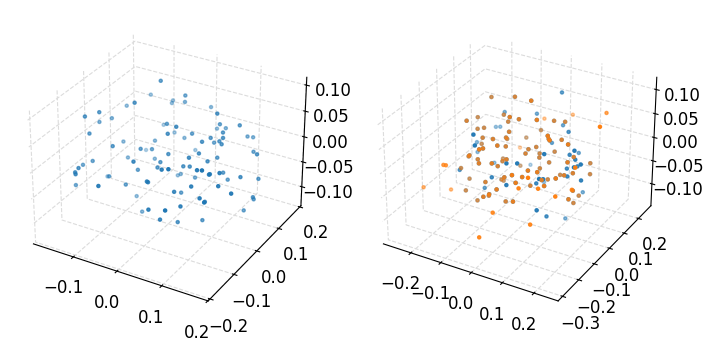

In [ ]:
dx0_proj = dx0 @ vh0.T
dx1_proj = dx1 @ vh1.T
dx0_next_proj = dx0_next @ vh1.T

fig, axes = plt.subplots(1, 2, figsize=(7, 5), subplot_kw={"projection": "3d"})
scatter_kwargs = {"s": 5.0}
axes[0].scatter(*dx0_proj.T, **scatter_kwargs)
axes[1].scatter(*dx1_proj.T, s=5.0)
axes[1].scatter(*dx0_next_proj.T, s=5.0)

In [ ]:
dx0_proj2, dx0_next_proj2 = dx0_proj[:, :-1], dx0_next_proj[:, :-1]

# TODO: Try PCA-based total least squares and see if things improve
A = np.linalg.pinv(dx0_proj2) @ dx0_next_proj2
A

array([[-0.85187543, -0.36779368],
       [ 0.35227392, -0.85220411]])

In [ ]:
dx0_next.shape

(102, 3)

In [ ]:
M = vh0.T[:, :-1] @ A @ vh1[:-1, :]
dx0_next_pred = dx0 @ M

In [ ]:
from dynamics_discovery.loss_functions import tangent_evolution_matrix


dF = tangent_evolution_matrix(lorenz_scaled, x0, dataset.t[0][0:2])[1][0]
dF

Array([[ 0.78036066,  0.21837272, -0.0344425 ],
       [-0.18175704,  0.90713455, -0.28407243],
       [ 0.18235843,  0.3367208 ,  0.8925116 ]], dtype=float64)

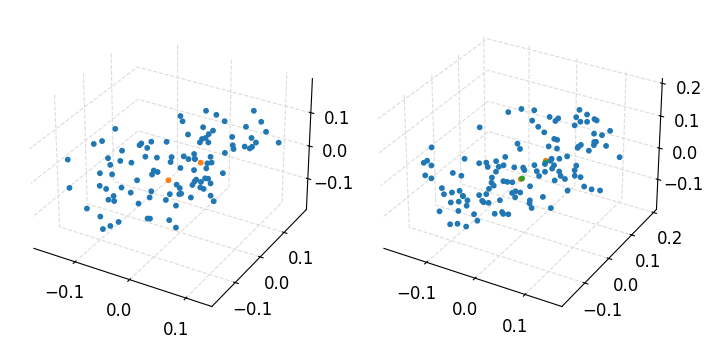

In [ ]:
test_points = 0.05 * np.array([[1, 0], [0, 1]]) @ vh0[:-1, :]
fig, axes = plt.subplots(1, 2, figsize=(7, 5), subplot_kw={"projection": "3d"})
scatter_kwargs = {"s": 10.0, "alpha": 1.0}
axes[0].scatter(*dx0.T, **scatter_kwargs)
axes[0].scatter(*test_points.T, **scatter_kwargs)

test_points1 = test_points @ dF.T
test_points1_pred = test_points @ M
axes[1].scatter(*dx1.T, **scatter_kwargs)
axes[1].scatter(*test_points1.T, **scatter_kwargs)
axes[1].scatter(*test_points1_pred.T, **scatter_kwargs)


In [ ]:
test_points1 - test_points1_pred

Array([[-4.61950080e-04,  2.41927751e-03,  3.80342585e-03],
       [-2.70342668e-03, -8.35641202e-05, -3.19901315e-03]],      dtype=float64)

In [ ]:
dx0_next - dx0_next_pred

array([[-1.26261760e-04, -5.97151322e-04,  5.98927727e-05],
       [-9.49732281e-05, -5.00463757e-04,  2.94539659e-05],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [-1.39807462e-04, -1.73728594e-04,  6.14998693e-05],
       [-8.02111484e-05, -1.69484020e-04,  1.65841330e-04],
       [-4.41912455e-05, -1.44363463e-04,  3.94408636e-04],
       [-7.44910462e-05,  4.29878868e-05,  3.97146931e-05],
       [-9.28247774e-06, -8.13084952e-05,  2.27847022e-04],
       [-4.97814136e-05, -4.28439365e-05, -4.80829102e-05],
       [ 5.53540699e-05, -5.05106756e-05,  1.90914154e-05],
       [ 7.14945229e-06, -5.90285192e-05, -7.89092212e-05],
       [ 1.19652943e-04, -1.13303102e-04,  3.48576089e-04],
       [ 9.84148039e-05, -1.03302869e-04,  3.13117320e-04],
       [ 1.91623973e-04, -1.32988895e-04, -1.83846436e-05],
       [ 1.85538159e-04, -1.78206056e-04, -1.62341869e-04],
       [ 1.44329867e-04, -3.63357463e-04, -3.52995792e-04],
       [ 9.63618725e-05, -4.39257135e-04

Array([[ 0.78008981,  0.21839677, -0.03414111],
       [-0.18325999,  0.90786088, -0.28154321],
       [ 0.1772501 ,  0.33296563,  0.89350924]], dtype=float64)

In [ ]:
M.T

array([[ 0.28675351,  0.44072445,  0.19231948],
       [ 0.14361059,  0.75925125, -0.43204797],
       [ 0.44857245,  0.2113752 ,  0.76988049]])

In [ ]:
np.linalg.eig(dF)

EigResult(eigenvalues=array([0.75820614+0.j       , 0.9116269 +0.3778437j,
       0.9116269 -0.3778437j]), eigenvectors=array([[-0.78126805+0.j        , -0.28828802-0.22840896j,
        -0.28828802+0.22840896j],
       [ 0.17208091+0.j        ,  0.11712421-0.63632836j,
         0.11712421+0.63632836j],
       [ 0.60000699+0.j        , -0.66789782+0.j        ,
        -0.66789782-0.j        ]]))

In [ ]:
u, s, vh = np.linalg.svd(np.concat((dx0, dx0_next), axis=1), full_matrices=False)
v = vh.T
M_tls = -v[:3, 3:] * np.linalg.pinv(v[3:, 3:])
M_tls

array([[-0.02365635,  0.10059665,  0.07830338],
       [-0.03786863,  0.11446082,  0.12543303],
       [ 0.36104828, -0.15517678,  0.00045344]])

In [ ]:
traj_ind, time_ind = 10, 100
radius = 0.1
tree = scspatial.KDTree(dataset.u[:, :-1].reshape(-1, 3))
u0, u1 = dataset.u[traj_ind, time_ind], dataset.u[traj_ind, time_ind + 1]

neighbors_inds = np.asarray(tree.query_ball_point(u0, radius))
u_neighbors = dataset.u[*np.divmod(neighbors_inds, dataset.u.shape[1] - 1)]

u_neighbors1 = dataset.u[
    np.divmod(neighbors_inds, dataset.u.shape[1] - 1)[0],
    np.divmod(neighbors_inds, dataset.u.shape[1] - 1)[1] + 1,
]

In [ ]:
rng = np.random.default_rng()
u_noise = dataset.u + rng.normal(scale=0.01, size=dataset.u.shape)
u0_noise = u_noise[traj_ind, time_ind]

tree_noise = scspatial.KDTree(u_noise[:, :-1].reshape(-1, 3))
neighbors_inds_noise = np.asarray(tree_noise.query_ball_point(u0_noise, radius))
u_neighbors_noise = u_noise[*np.divmod(neighbors_inds_noise, u_noise.shape[1] - 1)]

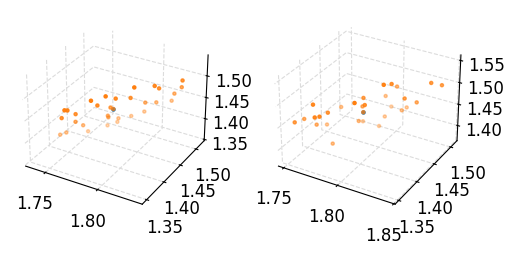

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(5, 3), subplot_kw={"projection": "3d"})
axes[0].scatter(*u0, s=5.0)
axes[0].scatter(*u_neighbors.T, s=5.0)

axes[1].scatter(*u0_noise, s=5.0)
axes[1].scatter(*u_neighbors_noise.T, s=5.0)


In [ ]:
u_neighbors_noise = u_neighbors + rng.normal(scale=0.1, size=u_neighbors.shape)
u_neighbors1_noise = u_neighbors1 + rng.normal(scale=0.1, size=u_neighbors.shape)
np.sqrt(np.mean((u_neighbors - u_neighbors_noise) ** 2))

np.float64(0.10530659358781011)

In [ ]:
du0_ = u_neighbors_noise - u0
u, s, vh = np.linalg.svd(du0_, full_matrices=False)
print(s)
s[-1] = 0
du0_pca = np.dot(u * s, vh)

[0.70791402 0.56527006 0.51662191]


In [ ]:
du1_ = u_neighbors1_noise - u1
u, s, vh = np.linalg.svd(du1_, full_matrices=False)
print(s)
s[-1] = 0
du1_pca = np.dot(u * s, vh)

[0.66691923 0.58299629 0.45760195]


In [ ]:
u_neighbors_pca = np.dot(u * s, vh) + np.mean(u_neighbors_noise, axis=0)

In [ ]:
np.sqrt(np.mean((u_neighbors - u_neighbors_pca) ** 2))

np.float64(0.0962144055910879)

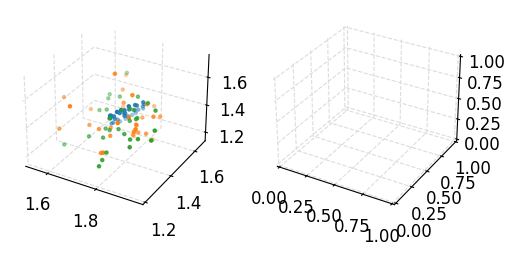

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(5, 3), subplot_kw={"projection": "3d"})
axes[0].scatter(*u_neighbors.T, s=5.0)
axes[0].scatter(*u_neighbors_noise.T, s=5.0)
axes[0].scatter(*u_neighbors_pca.T, s=5.0)

In [ ]:
dataset.t.shape

(50, 500)

In [ ]:
from dynamics_discovery.loss_functions import tangent_evolution_matrix


dF = tangent_evolution_matrix(lorenz_scaled, u0, dataset.t[0][0:2])[1][0]
dF

Array([[ 0.78008981,  0.21839677, -0.03414111],
       [-0.18325999,  0.90786088, -0.28154321],
       [ 0.1772501 ,  0.33296563,  0.89350924]], dtype=float64)

In [ ]:
du0, du1 = (
    u_neighbors - u0,
    u_neighbors1 - u1,
)

In [ ]:
du1

array([[-0.0373364 ,  0.01051103, -0.08455202],
       [-0.03294642,  0.01285805, -0.07782396],
       [ 0.        ,  0.        ,  0.        ],
       [-0.020994  ,  0.01381062, -0.05424628],
       [-0.02611074, -0.01593009, -0.03813585],
       [-0.03508672, -0.05673702, -0.01976455],
       [-0.00206313, -0.01126004,  0.00607854],
       [-0.02570751, -0.04792953, -0.00892192],
       [ 0.01139677, -0.01494954,  0.03617956],
       [-0.01102387, -0.04447208,  0.01719545],
       [ 0.00116505, -0.03959276,  0.03734152],
       [-0.03271723, -0.08354745,  0.00844787],
       [-0.03085208, -0.07776041,  0.00707366],
       [-0.015249  , -0.07561639,  0.03597018],
       [-0.0056276 , -0.06730389,  0.04774758],
       [ 0.0131587 , -0.05278904,  0.07233005],
       [-0.01763823,  0.04874799, -0.07951493],
       [ 0.00338029,  0.06417987, -0.050793  ],
       [-0.00368051,  0.06118905, -0.06213132],
       [ 0.02250051,  0.07042506, -0.0174995 ],
       [ 0.01319714,  0.06535496, -0.031

In [ ]:
A_ideal = du1.T @ np.linalg.pinv(du0.T)
A_ideal

array([[ 0.79822474,  0.21009502, -0.04249977],
       [ 0.01814804,  0.81588138, -0.37443758],
       [ 0.21492831,  0.31674052,  0.87714985]])

In [ ]:
A_pca = du1_pca.T @ np.linalg.pinv(du0_pca.T)
A_pca

array([[ 0.0159469 ,  0.19220946,  0.12581748],
       [ 0.0109663 , -0.3524818 ,  0.12711453],
       [ 0.02127572, -0.11943761,  0.19934239]])

In [ ]:
u, s, vh = np.linalg.svd(np.concat((du0, du1), axis=1), full_matrices=False)
v = vh.T
A_pca2 = -v[:3, 3:] * np.linalg.pinv(v[3:, 3:])
A_pca2

array([[-0.02365635,  0.10059665,  0.07830338],
       [-0.03786863,  0.11446082,  0.12543303],
       [ 0.36104828, -0.15517678,  0.00045344]])

array([[ 0.13268816, -0.34075655,  0.62340128,  0.00782881, -0.50903817,
         0.46740616],
       [ 0.35472941,  0.56853356,  0.21501504,  0.39346249,  0.38978942,
         0.4449232 ],
       [-0.67235961,  0.13831943,  0.21925253, -0.47406775,  0.33858339,
         0.375965  ],
       [-0.13990687,  0.63226298, -0.28719756, -0.12068819, -0.68014299,
         0.14500699],
       [ 0.07118418, -0.36726109, -0.65918422,  0.03988967,  0.05356492,
         0.64889744],
       [-0.61632162, -0.08297663,  0.00783845,  0.77732163, -0.0940316 ,
        -0.01141177]])

In [ ]:
np.linalg.eig(dF)

EigResult(eigenvalues=array([0.75820614+0.j       , 0.9116269 +0.3778437j,
       0.9116269 -0.3778437j]), eigenvectors=array([[-0.78126805+0.j        , -0.28828802-0.22840896j,
        -0.28828802+0.22840896j],
       [ 0.17208091+0.j        ,  0.11712421-0.63632836j,
         0.11712421+0.63632836j],
       [ 0.60000699+0.j        , -0.66789782+0.j        ,
        -0.66789782-0.j        ]]))

In [ ]:
np.linalg.eig(A_ideal)

EigResult(eigenvalues=array([0.68278477+0.j        , 0.9042356 +0.37222597j,
       0.9042356 -0.37222597j]), eigenvectors=array([[-0.8565037 +0.j        , -0.28705114-0.23586882j,
        -0.28705114+0.23586882j],
       [ 0.49803273+0.j        ,  0.13746825-0.62758531j,
         0.13746825+0.62758531j],
       [ 0.13551685+0.j        , -0.67022885+0.j        ,
        -0.67022885-0.j        ]]))

In [ ]:
np.linalg.eig(A_pca)

EigResult(eigenvalues=array([ 1.90275399e-01,  1.56125113e-17, -3.27467916e-01]), eigenvectors=array([[ 0.69674796,  0.99370237,  0.53453637],
       [ 0.17688617, -0.0093522 , -0.81931689],
       [ 0.69516441, -0.11166085, -0.207342  ]]))

In [ ]:
np.linalg.eig(A_pca2)

EigResult(eigenvalues=array([ 0.17682047+0.j       , -0.04278128+0.0750658j,
       -0.04278128-0.0750658j]), eigenvectors=array([[-0.53644383+0.j        ,  0.32140295-0.04561027j,
         0.32140295+0.04561027j],
       [-0.67989691+0.j        ,  0.54355615+0.24850393j,
         0.54355615-0.24850393j],
       [-0.49996821+0.j        , -0.73308414+0.j        ,
        -0.73308414-0.j        ]]))

In [ ]:
u, s, vh = np.linalg.svd(np.concat((du0, du1), axis=1), full_matrices=False)
s

array([4.52431549e-01, 3.61017774e-01, 1.19856395e-03, 9.61469375e-04,
       7.49802354e-04, 2.72282128e-06])

In [ ]:
s[3:] = 0
A_pca2 = np.dot(u * s, vh)
A_pca2.shape

(7, 6)

In [ ]:
u./

(7, 6)

array([[ 0.02682566, -0.01523691,  0.8440932 ],
       [-0.28770947, -0.56483382, -0.0032583 ],
       [ 0.50767556,  0.01195736,  0.01782019]])